# Flight Delay Prediction
## Introduction
In our project, we try to predict whether a flight would delay or not with local weather observations. We also try to predict which 15-minute interval the arrival of a flight falls into. We chose the flight route from the 3 major  airports around New York City (i.e. LaGuardia, Newark, JFK) and landing at two larger airports in Miami (Miami, Fort Lauderdale). This flight route was chosen for several reasons. First, they are in the same time zone (which solved some problems that would be discussed later). Second, the amount of flights were large enough, more than 70 flights per day in average. Third, the airports in New York City are notorious for there poor on-time performance, especially when taking weather into account. These reasons made it seem wise to start our project from this route, although other routes might also work as well.

#### Requirements
```
pip3 install numpy pandas lxml bs4
```

In [3]:
import numpy as np
import pandas as pd
import requests

## Data Collection
### Flight Data
We get our flight data from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time). The database itself is not program-friendly, you'll have to fetch the data manually to get the data. But after looking into the requests, we found out that the form data sent along with the request is actually a raw SQL query (which is quite dangerous in a public site), and we can get the data needed in a single request.

In [3]:
# Fetching data from BTS database

import zipfile
import io

def get_data_csv():
    years_interval = ["2015","2018"]
    req_header = {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
        "Cache-Control": "no-cache",
        "Connection": "keep-alive",
        "Content-Type": "application/x-www-form-urlencoded",
        "Cookie": "ASPSESSIONIDCQCDRTCQ=FKGMOCEDMCDHINELAEGCEIKN",
        "Host": "www.transtats.bts.gov",
        "Origin": "https://www.transtats.bts.gov",
        "Pragma": "no-cache",
        "Referer": "https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36"
    }
    data_url = "https://www.transtats.bts.gov/DownLoad_Table.asp?Table_ID=236&Has_Group=3&Is_Zipped=0"
    pair_form_data = {
    "UserTableName":"On_Time_Performance",
    "DBShortName":"On_Time",
    "RawDataTable":"T_ONTIME",
    "sqlstr":\
            "SELECT YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_GROUP,DISTANCE,CANCELLED,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY \
            FROM T_ONTIME \
            WHERE (\
                DEST IN ('EWR','JFK','LGA','MIA','FLL') OR\
                ORIGIN IN ('EWR','JFK','LGA','MIA','FLL')\
            )\
            AND \
            Month BETWEEN 1 AND 12 AND \
            YEAR BETWEEN {} AND {}".format(years_interval[0],years_interval[1]),
    "varlist":"YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_GROUP,DISTANCE,CANCELLED,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY",
    }
    r = requests.post(data_url,
                      data=pair_form_data,
                      headers=req_header,
                     )
    z = zipfile.ZipFile(io.BytesIO(r.content))
    return pd.read_csv(io.BytesIO(z.read(z.infolist()[0])),
                       dtype={
                          "CRS_DEP_TIME":str,
                          "DEP_TIME":str,
                          "CRS_ARR_TIME":str,
                          "ARR_TIME":str,
                          "CANCELLED":bool,
                          "DIVERTED":bool},
                      usecols=list(range(24))
                      )

### Weather Data
In the beginning, we thought that historical weather data is easy to find. Turns out it's a bit harder than we thought to obtain free weather data in such a fine-grain scale. We did some extra research and [www.wunderground.com](Weather Underground) had statically rendered hourly historical weather data pages, but the API was not public. We had to parse the weather data with BeautifulSoup. Since we have 5 airports spanning out a bit over 3 years, it took some time for us to parse all the data.

In [8]:
# scraping hourly weather data from wunderground.com

import lxml
from multiprocessing.dummy import Pool
from bs4 import BeautifulSoup

NYC_AIRPORTS = ["EWR","JFK","LGA"]
MIA_AIRPORTS = ["FLL","MIA"]

def wind_speed_conv(x):
    try:
        ret = 0.0 if x == "Calm" else float(x)
    except:
        ret = np.NaN
    return ret
DIR_ANGLE={
            "North": 0,"NNE": 1,"NE": 2,"ENE": 3,"East": 4,"ESE": 5,"SE": 6,"SSE": 7,
            "South": 8,"SSW": 9,"SW":10,"WSW":11,"West":12,"WNW":13,"NW":14,"NNW":15,
          }
def wind_dir_conv(x):
    return np.NaN if x not in DIR_ANGLE else 22.5*DIR_ANGLE[x]
def humidity_conv(x):
    try:
        ret = float(x.strip("%"))/100
    except:
        ret = np.NaN
    return ret
def precip_conv(x):
    try:
        ret = 0.0 if x == "N/A" else float(x)
    except:
        ret = 0.0
    return ret
def event_conv(x):
    return "".join(x.split("\t"))


def table_parser(pair):
    url, date, airport = pair
    content = requests.get(url).content
    def time_conv(x):
        return date + " " + x
    bs = BeautifulSoup(content, "html5lib")
    table_html = bs.find(id="obsTable")
    for unit_tag in table_html.find_all("span",class_="wx-unit"):
        unit_tag.decompose()
    table_df = pd.read_html(str(table_html), converters= \
                            {
                                "Time (EST)":time_conv,
                                "Time (EDT)":time_conv,
                                "Wind Speed":wind_speed_conv,
                                "Wind Dir":wind_dir_conv,
                                "Precip":precip_conv,
                                "Humidity":humidity_conv,
                                "Events":event_conv
                            })[0]
    table_df = table_df.drop(["Windchill", "Dew Point", "Gust Speed"],axis=1, errors="ignore")
    table_df.rename(columns={"Time (EST)":"Time", "Time (EDT)":"Time", "Temp.":"Temp"}, inplace=True)
    table_df["Time"] = pd.to_datetime(table_df["Time"])
    table_df.set_index("Time", inplace=True)
    table_df["Airport"] = airport
    return table_df

def weather_scraper(dates):
    # Run once. Slow to run.
    base_url = "https://www.wunderground.com/history/airport/K{}/{}/DailyHistory.html"
    
    pool = Pool(8)
    pairs = []
    for airport in NYC_AIRPORTS + MIA_AIRPORTS:
        for date in dates:
            date_str = date.strftime("%Y/%m/%d")
            url = base_url.format(airport, date_str)
            pairs.append((url, date_str, airport))
            
    weather_df_list = pool.map(table_parser, pairs)
    pool.close()
    pool.join()
            
    result = pd.concat(weather_df_list)
    result.to_csv("weather.csv")
    return result

After fetching the weather data, we classify the conditions of the weather into different categories. We split up some compound conditions such as "Thunderstorms and Rain" into "Thunderstorm" and "Rain" to reduce the degree of freedom.

In [12]:
weather = pd.read_csv("weather.csv", low_memory=False, parse_dates=["Time"], na_values=["-"], index_col="Time")
weather = weather.drop("Heat Index",axis=1)

condition_dict={
    "Clear":"Clear",
    "Mostly Cloudy":"Mostly Cloudy",
    "Partly Cloudy":"Partly Cloudy",
    "Scattered Clouds":"Scattered Clouds",
    "Overcast":"Overcast",
    "Light Snow":"Light Snow",
    "Light Rain":"Light Rain",
    "Snow":"Snow",
    "Light Drizzle":"Light Drizzle",
    "Rain":"Rain",
    "Fog":"Fog",
    "Light Freezing Drizzle":"Light Freezing Drizzle",
    "Light Freezing Rain":"Light Freezing Rain",
    "Heavy Rain":"Heavy Rain",
    "Thunderstorms and Rain":"Thunderstorm|Rain",
    "Heavy Snow":"Heavy Snow",
    "Light Ice Pellets":"Light Ice Pellets",
    "Blowing Snow":"Blowing Snow",
    "Haze":"Haze",
    "Ice Pellets":"Ice Pellets",
    "Light Thunderstorms and Rain":"Light Rain|Thunderstorm",
    "Heavy Thunderstorms and Rain":"Heavy Rain|Thunderstorm",
    "Thunderstorm":"Thunderstorm",
    "Mist":"Mist",
    "Light Rain Showers":"Light Rain Showers",
    "Unknown":"Unknown",
    "Shallow Fog":"Shallow Fog",
    "Heavy Ice Pellets":"Heavy Ice Pellets",
    "Heavy Thunderstorms with Ice Pellets":"Heavy Ice Pellets|Thunderstorm",
    "Squalls":"Squalls",
    "Patches of Fog":"Patches of Fog",
    "Smoke":"Smoke",
    "Light Freezing Fog":"Light Freezing Fog",
    "Funnel Cloud":"Funnel Cloud"
}
weather["Conditions"] = weather["Conditions"].apply(lambda x: condition_dict[x])

We also had to handle some boundary conditions that happen on the transition between Daylight Saving Time and standard time. Thus it was important that we chose two metropolitans that are in the same timezone, so we won't have a lot of transitions happening at the same time.

In [13]:
# handle weather with DST
new_weather_list = []
for a in NYC_AIRPORTS+MIA_AIRPORTS:
    weather_airport_idx = weather[weather["Airport"]==a].index
    weather_airport_tz_idx = weather_airport_idx.tz_localize('US/Eastern', ambiguous='infer')
    new_weather = weather[weather["Airport"]==a].set_index(weather_airport_tz_idx)
    new_weather_list.append(new_weather[~new_weather.index.duplicated()])
new_weather = pd.concat(new_weather_list)
    
new_weather.sort_index(inplace=True)

In [4]:
# Uncomment these lines to download the flight data
# raw_data = get_data_csv()
# raw_data.to_csv("data.csv", index=False)
raw_data = pd.read_csv("data.csv",dtype={
                          "CRS_DEP_TIME":str,
                          "DEP_TIME":str,
                          "CRS_ARR_TIME":str,
                          "ARR_TIME":str,
                          "CANCELLED":bool,
                          "DIVERTED":bool})
raw_data[["DEP_DELAY","ARR_DELAY"]] = raw_data[["DEP_DELAY","ARR_DELAY"]].fillna(0)

# Uncomment these lines to download weather data
# weather_scraper(raw_data.index.unique())

We now read in the flight data and remove invalid entries. We then handle the time on both ends of the flight. We had to handle dates of overnight flights since only the date of the departure was listed in the data.

In [5]:
data = raw_data[~(raw_data["DIVERTED"] | raw_data["CANCELLED"])].drop(["CANCELLED","DIVERTED"], axis=1)

time_cols = ["CRS_DEP_TIME", "CRS_ARR_TIME"]
for col in time_cols:
    data.loc[data[col]=="2400",col] = "0000"
    data[col.rsplit("_",1)[0]+"_DATETIME"] = \
    pd.to_datetime(data["FL_DATE"]+" "+data[col], format="%Y-%m-%d %H%M")
    
# check if arrival time is after departure
data.loc[(data['CRS_ARR_DATETIME'] < data['CRS_DEP_DATETIME']), 'CRS_ARR_DATETIME'] += pd.Timedelta(days=1)
data['CRS_DEP_DATETIME'] = pd.DatetimeIndex(data["CRS_DEP_DATETIME"]).tz_localize("US/Eastern", ambiguous=False, errors="coerce")
data['CRS_ARR_DATETIME'] = pd.DatetimeIndex(data["CRS_ARR_DATETIME"]).tz_localize("US/Eastern", ambiguous=False, errors="coerce")

data["DEP_DATETIME"] = data["CRS_DEP_DATETIME"] + pd.to_timedelta(data["DEP_DELAY"], unit="m")
data["ARR_DATETIME"] = data["CRS_ARR_DATETIME"] + pd.to_timedelta(data["ARR_DELAY"], unit="m")
data = data[~(data[["DEP_DATETIME","ARR_DATETIME"]].isnull().any(axis=1))]

In [9]:
mia_data = data.drop(time_cols+["DEP_TIME", "ARR_TIME"],axis=1)
mia_data = mia_data[mia_data["DEST"].isin(MIA_AIRPORTS) & mia_data["ORIGIN"].isin(NYC_AIRPORTS)]
mia_data["date"] = pd.to_datetime(mia_data["FL_DATE"])
mia_data = mia_data.set_index("date").sort_index()

We now merge the two data. However, since our weather data was collected down to an hourly granularity, the flights were aligned to the nearest weather datapoint before there scheduled departure/arrival so we can't cheat on looking on data in the future. Thankfully, the merging was not that complicated by using the `merge_asof` function.

In [14]:
temp_df = pd.merge_asof(mia_data.sort_values("CRS_DEP_DATETIME"), new_weather, left_by=["ORIGIN"], right_by=["Airport"], left_on="CRS_DEP_DATETIME", right_index=True)
weather_flight_data = pd.merge_asof(temp_df.sort_values("CRS_ARR_DATETIME"), new_weather, left_by=["DEST"], right_by=["Airport"], left_on="CRS_ARR_DATETIME", right_index=True, suffixes=["_dep","_arr"])

Since it is common that a delay of one aircraft will propagate to later flights and cause subsequent flights to delay, we decided to extract this feature from the data. We extracted the tail number, which should identify planes uniquely, from each flight and found the delay of each flight's aircraft's previous delay. However, if the time of arrival between flights of the same aircraft is large, the delay might not be passed down, so we also took this into account and added the boolean features indicating if the previous arrival of the departing flight is larger than a day and six hours.

In [15]:
weather_flight_data = pd.merge_asof(weather_flight_data.sort_values("CRS_DEP_DATETIME"),
                                    data[["ARR_DATETIME","TAIL_NUM","DEST","ARR_DELAY"]].sort_values("ARR_DATETIME"),
                                    left_by=["TAIL_NUM","ORIGIN"],
                                    right_by=["TAIL_NUM","DEST"],
                                    left_on="CRS_DEP_DATETIME",
                                    right_on="ARR_DATETIME",
                                    suffixes=("","_PREV"),
                                    allow_exact_matches=False)
weather_flight_data["PREV_ARR_LT_ONE_DAY"] = (weather_flight_data["CRS_DEP_DATETIME"] - weather_flight_data["ARR_DATETIME_PREV"] < pd.Timedelta(days=1)).astype(int)
weather_flight_data["PREV_ARR_LT_SIX_HOURS"] = (weather_flight_data["CRS_DEP_DATETIME"] - weather_flight_data["ARR_DATETIME_PREV"] < pd.Timedelta(hours=6)).astype(int)
weather_flight_data.drop(["ARR_DATETIME_PREV", "DEST_PREV"],axis=1, inplace=True)
weather_flight_data["ARR_DELAY_PREV"] = weather_flight_data["ARR_DELAY_PREV"].fillna(0)


Lastly, delays might be caused by high traffic in the airport. We therefore calculated the number of take offs and landings in a certain interval around the scheduled departure and arrival of each flight, and also summed them up.

In [16]:
flights_interval_list = []
interval_len = "30T"
for a in NYC_AIRPORTS+MIA_AIRPORTS:
    takeoff = pd.DataFrame(index=data.loc[data["ORIGIN"]==a, "CRS_DEP_DATETIME"])
    takeoff["TAKEOFF_INTV"] = 1
    landing = pd.DataFrame(index=data.loc[data["DEST"]==a, "CRS_ARR_DATETIME"])
    landing["LANDING_INTV"] = 1
    airport_flight_times = takeoff.join(landing,how="outer").fillna(0).groupby(level=0).sum()
    rev_aft_idx = pd.datetime(1970,1,1,0,0)+(-(airport_flight_times.index[::-1]-airport_flight_times.index[-1]))
    airport_flights_interval = airport_flight_times.rolling(interval_len,closed="left").sum().fillna(0)+\
                          airport_flight_times[::-1].set_index(rev_aft_idx).rolling(interval_len, closed="both").sum()[::-1].set_index(airport_flight_times.index)
    airport_flights_interval["TOTAL_INTV"] = airport_flights_interval.sum(axis=1)
    airport_flights_interval["AIRPORT"] = a
    flights_interval_list.append(airport_flights_interval)
flights_interval_df = pd.concat(flights_interval_list).reset_index().rename(index=str,columns={"index":"DATETIME"})

In [17]:
temp_df = weather_flight_data.merge(flights_interval_df, left_on=["ORIGIN","CRS_DEP_DATETIME"],right_on=["AIRPORT","DATETIME"]).drop(["AIRPORT","DATETIME"],axis=1)
weather_flight_data = temp_df.merge(flights_interval_df, left_on=["DEST","CRS_ARR_DATETIME"],right_on=["AIRPORT","DATETIME"],suffixes=("_ORIGIN","_DEST")).drop(["AIRPORT","DATETIME"],axis=1)

### Exploratory Analysis



In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Imbalanced Data
The statistics below are the number of delay vs non-delay flights. After data preprocessing, the number of non-delayed flights is about twice of the number of delayed flights. Thus, our dataset is considered to be quite imbalance. Such observation affects our selection of evaluation metrics. On top of accuracy, we decide to look at the F-score in order to take the imbalance characteristic of our data into account.

In [19]:
print('Number of On-Time Flights: ', weather_flight_data[weather_flight_data['ARR_DELAY_GROUP'] < 0].shape[0])
print('Number of Delayed Flights: ', weather_flight_data[weather_flight_data['ARR_DELAY_GROUP'] >= 0].shape[0])

Number of On-Time Flights:  53810
Number of Delayed Flights:  32515


#### Fligt Delay vs Carrier
We are curious whether different US carriers is an important cause of flight delays. The figure below is a bar plot of each carrier and its probability of flight delays. As you can see, the delay probability varies between different carriers. Although imbalanced flight numbers may also contribute to this observation, we decided to add carrier as one of our categorical training feature.


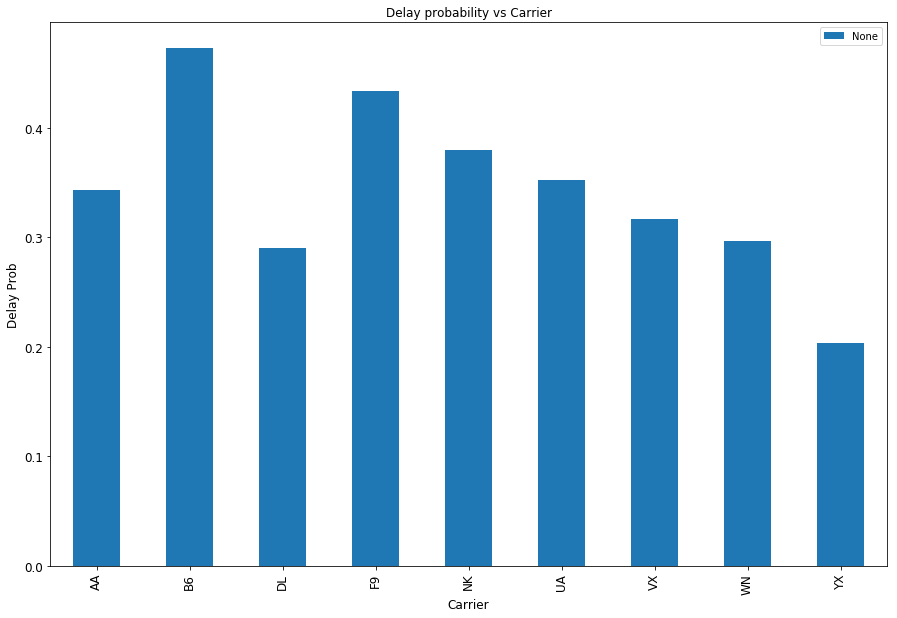

In [23]:
#weather_flight_data
carrier_prob = weather_flight_data[['CARRIER','ARR_DELAY']]\
                .groupby(['CARRIER'], group_keys=False)\
                .apply(lambda x: x[x['ARR_DELAY']>0].shape[0]/x.shape[0])
ax = carrier_prob.plot(kind='bar', title ="Delay probability vs Carrier", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Carrier", fontsize=12)
ax.set_ylabel("Delay Prob", fontsize=12)
plt.show()

#### Flight Delay vs Weather Condition
Here we looked at the relationship between flight delays and weather condition. The figure below shows the delay probability under each weather condition. Here, we can see that the probabilities varies greatly under different weather conditions, even more significant than differet carriers. This gives us the intuition that adding weather related features may benefit the flight delay predictions.

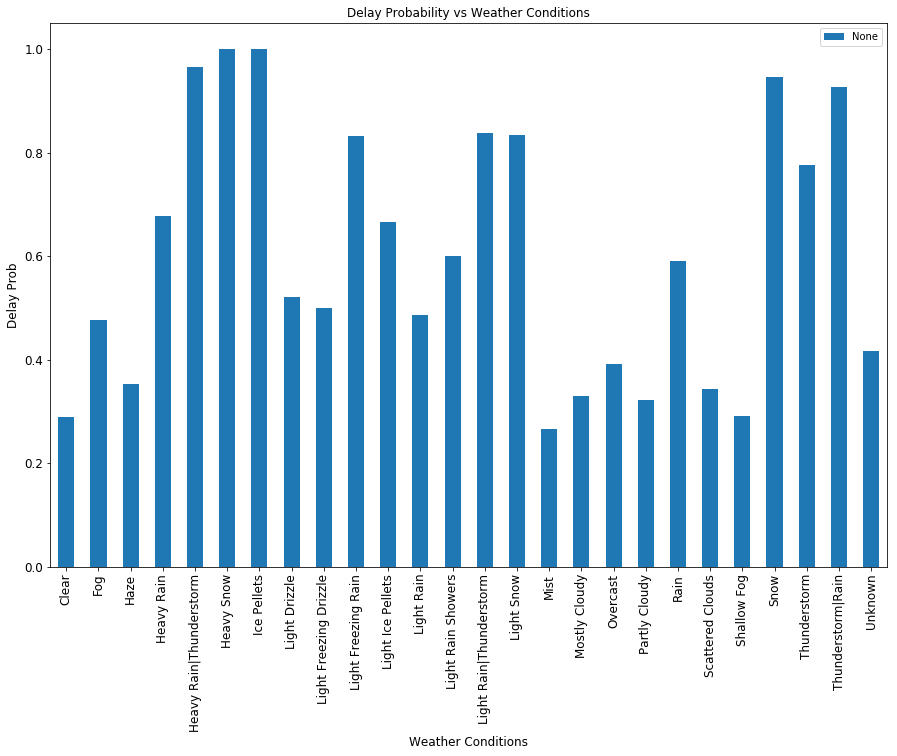

In [24]:
Conditions_arr_prob = weather_flight_data[['Conditions_dep','ARR_DELAY']]\
                .groupby(['Conditions_dep'], group_keys=False)\
                .apply(lambda x: x[x['ARR_DELAY']>0].shape[0]/x.shape[0])
ax = Conditions_arr_prob.plot(kind='bar', title ="Delay Probability vs Weather Conditions", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Weather Conditions", fontsize=12)
ax.set_ylabel("Delay Prob", fontsize=12)
plt.show()

### Feature Engineering

Here are the features used for our baseline model. Categorical features were turned them into one-hot encoding using the get_dummies() function. As for cyclical features, our model includes both the sine and cosine transformation hoping to capture the seasonal nature of these features.

| Feature | Type | Description |
| ------|------|------:|
| MONTH | Cyclical | month of departure flight |
| DAY_OF_WEEK | Cyclical | day of week of departure flight|
| CARRIER | Categorical | carrier of the flight|
| DEST | Categorical | arrival airport|
| ORIGIN | Categorical | departure airport|
| CRS_ARR_HOUR | Cyclical | estimated arrival time | 
| CRS_DEP_HOUR | Cyclical | estimated departure time | 

In addition to the baseline features, we also added weather related features such as weather condition, precepitation, pressure, tempurature, visibility, etc. On top of that, we also added features indicating whether the previous aircraft is delayed or not. The table below shows the final list of features that were included. We did the same thing for categorical and cyclical features and normalized all the numerical features.

| Feature | Type | Description |
| ------|------|------:|
| MONTH | Cyclical | month of departure flight |
| DAY_OF_WEEK | Cyclical | day of week of departure flight|
| CARRIER | Categorical | carrier of the flight|
| DEST | Categorical | arrival airport|
| ORIGIN | Categorical | departure airport|
| CRS_ARR_HOUR | Cyclical | estimated time of arrival | 
| CRS_DEP_HOUR | Cyclical | estimated time of departure | 
| Humidity_{dep,arr} | Numerical | humidity before departure/after arrival |
| Precipitation_{dep,arr} | Numerical | precipitation before departure/after arrival |
| Pressure_{dep,arr} | Numerical | precipitation before departure/after arrival |
| Temperature_{dep,arr} | Numerical | temperature before departure/after arrival |
| Visibility_{dep,arr} | Numerical | visibility before departure/after arrival |
| Wind Speed_{dep/arr} | Numerical | wind speed before departure/after arrival |
| Conditions_{dep/arr} | Categorical | weather condition before departure/after arrival |
| Wind Dir_{dep/arr} | Cyclical | wind direction before departure/after arrival | 
| Wind_{dep/arr} | Cyclical | product of Wind Speed_dep and Wind Dir_dep | 
| CRS_DEP_TOD | Cyclical | estimated time of day of departure |
| ARR_DELAY_PREV | Binary | whether the previous aircraft is delayed | 
| PREV_ARR_LT_ONE_DAY | Binary | whether the previous aircraft landed over a day ago | 
| PREV_ARR_LT_SIX_HOURS | Binary | whether the previous aircraft landed over six hours ago |
| {TAKEOFF,LANDING}\_INTV\_{ORIGIN,DEST} | Numerical | number of flights taking off/landing at the departure/arrival airport within half an hour of the scheduled departure/arrival time | 
| TOTAL\_INTV\_{ORIGIN,DEST} | Numerical | total number of flights (taking off + landing) at the departure/arrival airport within half an hour of the departure time |

It is mentionable that we did not use any feature related to the actual departure time since that would be a biased feature that would not be available before the flight actually happens.

In [20]:
from sklearn import preprocessing
def normalize(feature_list,feature_df):
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    for f in feature_list:        
        x_scaled = min_max_scaler.fit_transform(feature_df[[f]].values.astype(float))
        feature_df[f]= pd.DataFrame(x_scaled)
        
    return feature_df


features = ['MONTH', 'DAY_OF_WEEK', 'CARRIER', 'ORIGIN',
            'DEST', 'DEP_DELAY','ARR_DELAY_GROUP', 'ARR_DELAY', 'CRS_ARR_DATETIME',
            'CRS_DEP_DATETIME', 'Conditions_dep', 'Humidity_dep',
            'Precip_dep', 'Pressure_dep', 'Temp_dep', 'Visibility_dep',
            'Wind Dir_dep', 'Wind Speed_dep',  'Conditions_arr',
            'Humidity_arr', 'Precip_arr', 'Pressure_arr', 'Temp_arr',
            'Visibility_arr', 'Wind Dir_arr', 'Wind Speed_arr',
            'ARR_DELAY_PREV','PREV_ARR_LT_ONE_DAY','PREV_ARR_LT_SIX_HOURS',
            'TAKEOFF_INTV_ORIGIN','LANDING_INTV_ORIGIN','TAKEOFF_INTV_DEST','LANDING_INTV_DEST',
            'TOTAL_INTV_ORIGIN','TOTAL_INTV_DEST']
all_df = weather_flight_data[features]
all_df = all_df.dropna(axis=0, how='any', subset=set(all_df.columns) - set(["Wind Dir_arr", "Wind Dir_dep"]))
y_df = all_df['ARR_DELAY'].reset_index(drop=True)
all_df = all_df.drop(['ARR_DELAY_GROUP','ARR_DELAY'],axis=1).reset_index(drop=True)

def sincos(df,feature_list,freq_list):
    for feature, freq in zip(feature_list, freq_list):
        df[feature+"_SIN"] = np.sin(df[feature]/freq*2*np.pi).fillna(0)
        df[feature+"_COS"] = np.cos(df[feature]/freq*2*np.pi).fillna(0)
        
sincos(all_df,["MONTH", "DAY_OF_WEEK", "Wind Dir_arr", "Wind Dir_dep"],[12, 7, 360, 360])
all_df = all_df.drop(["MONTH","DAY_OF_WEEK", "Wind Dir_arr", "Wind Dir_dep"], axis=1)

norm_list = ['Pressure_dep','Pressure_arr','Temp_arr','Temp_dep','Visibility_dep','Visibility_arr',
             "TAKEOFF_INTV_ORIGIN","LANDING_INTV_ORIGIN","TAKEOFF_INTV_DEST",
             "LANDING_INTV_DEST","TOTAL_INTV_ORIGIN","TOTAL_INTV_DEST"]
feature_df = pd.get_dummies(all_df.drop(["Conditions_dep","Conditions_arr"],axis=1))
feature_df = normalize(norm_list,feature_df)
feature_df = pd.concat([
        feature_df,
        all_df["Conditions_dep"].str.get_dummies().add_prefix("Conditions_dep_"),
        all_df["Conditions_arr"].str.get_dummies().add_prefix("Conditions_arr_")
    ],
    axis=1)

feature_df['Wind_arr_SIN'] = feature_df['Wind Dir_arr_SIN'] * feature_df['Wind Speed_arr']
feature_df['Wind_arr_COS'] = feature_df['Wind Dir_arr_COS'] * feature_df['Wind Speed_arr']
feature_df['Wind_dep_SIN'] = feature_df['Wind Dir_dep_SIN'] * feature_df['Wind Speed_dep']
feature_df['Wind_dep_COS'] = feature_df['Wind Dir_dep_COS'] * feature_df['Wind Speed_dep']
feature_df['CRS_ARR_HOUR_SIN'] = np.sin(feature_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
feature_df['CRS_ARR_HOUR_COS'] = np.cos(feature_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
feature_df['CRS_DEP_HOUR_SIN'] = np.sin(feature_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
feature_df['CRS_DEP_HOUR_COS'] = np.cos(feature_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
dt = feature_df["CRS_DEP_DATETIME"].dt
time_of_day = 2*np.pi*(dt.hour*60+dt.minute)/3600
feature_df['CRS_DEP_TOD_SIN'] = np.sin(time_of_day)
feature_df['CRS_DEP_TOD_COS'] = np.cos(time_of_day)
feature_df = feature_df.drop(['CRS_ARR_DATETIME','CRS_DEP_DATETIME','DEP_DELAY', 'Wind Dir_arr_SIN', 'Wind Dir_dep_COS'],axis=1)

baseline_df = all_df[["CARRIER","MONTH_SIN","MONTH_COS","DAY_OF_WEEK_SIN","DAY_OF_WEEK_COS","CRS_ARR_DATETIME","CRS_DEP_DATETIME","DEST","ORIGIN"]]

baseline_df = pd.get_dummies(baseline_df)
baseline_df['CRS_ARR_HOUR_SIN'] = np.sin(baseline_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
baseline_df['CRS_ARR_HOUR_COS'] = np.cos(baseline_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
baseline_df['CRS_DEP_HOUR_SIN'] = np.sin(baseline_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
baseline_df['CRS_DEP_HOUR_COS'] = np.cos(baseline_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
baseline_df = baseline_df.drop(['CRS_ARR_DATETIME','CRS_DEP_DATETIME'],axis=1)

### Experiments and Model Training 

In our experiments, we would try two kinds of classification. One would be binary classification and the other would be multi-class classification.<br>
**Binary Classification** - predict whether a flight would delay or not<br>
**Multi-class Classification** - divide the delays into intervals and assign to them to the corresponding class shown in the table underneath

| Class | Delay |
| ------|------:|
| -2  | Delay < -15 minutes |
| -1  | Delay between -15 and -1 minutes|
| 0   | Delay between 0 and 14 minutes |
| 1   | Delay between 15 and 29 minutes |
| 2   | Delay between 30 and 44 minutes |
| ...   | ... |
| 11  | Delay between 165 and 179 minutes |
| 12  | Delay >= 180 minutes |

###  Baseline [Support Vector Machine] 
#### Binary Classification 
For the baseline, we used a support vector machine to do a binary classification of whether a specific flight would delay or not given the features that we have extracted.

In [29]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
# train baseline
X_baseline = baseline_df.values
y_binary = (y_df > 0).astype(int)
X_baseline, X_test_baseline, y_baseline, y_test_baseline = train_test_split(X_baseline, y_binary, test_size=0.1, random_state=42)

In [22]:
print('On-time flights count = ',y_binary[y_binary==0].size)
print ('Delay flights count =',y_binary[y_binary==1].size)

On-time flights count =  54893
Delay flights count = 31350


We could see from the counts of delay and non delay flights, the data is considered as a bit unbalanced.

In [42]:
clf = LinearSVC(random_state=0)
clf.fit(X_baseline, y_baseline)
pred_train_baseline = clf.predict(X_baseline)
pred_test_baseline = clf.predict(X_test_baseline)

acc_train_baseline = accuracy_score(y_baseline, pred_train_baseline)
acc_test_baseline = accuracy_score(y_test_baseline, pred_test_baseline)

prec_train_baseline = precision_score(y_baseline, pred_train_baseline)
prec_test_baseline = precision_score(y_test_baseline, pred_test_baseline)

F1_train_baseline = f1_score(y_baseline, pred_train_baseline)
F1_test_baseline = f1_score(y_test_baseline, pred_test_baseline)


In [43]:
print ("Training Accuracy = ",acc_train_baseline)
print("Testing Accuracy = ",acc_test_baseline)

print('===============================')
print ("Training Precision = ",prec_train_baseline)
print("Testing Precision = ",prec_test_baseline)

print('===============================')
print ("Training F score = ",F1_train_baseline)
print("Testing F score = ",F1_test_baseline)

Training Accuracy =  0.659061042542
Testing Accuracy =  0.659942028986
Training Precision =  0.585721271394
Testing Precision =  0.594013096352
Training F score =  0.311594391405
Testing F score =  0.302165120152


 
You could see for the results that the training and testing accuracy is around 65%. And since the amount of the delay and non delay flights in our data is unbalanced, we also used F score to evaluate our results. The F score is around 0.33 for our baseline

#### Multi-class Classification 

In [23]:
# predict multiclass
X = feature_df.values
X_baseline = baseline_df.values
y_raw = (y_df.values/15).astype(int)
X, X_test, y, y_test = train_test_split(X, y_raw, test_size=0.1, random_state=42)
X_baseline, X_baseline_test, y_baseline, y_test = train_test_split(X_baseline, y_raw, test_size=0.1, random_state=42)

In [45]:
# SVM multiclass baseline
clf = LinearSVC(random_state=0)
clf.fit(X_baseline,  y_baseline)

pred_train = clf.predict(X_baseline)
pred_test = clf.predict(X_baseline_test)

acc_train_multi = accuracy_score(y_baseline, pred_train)
acc_test_multi = accuracy_score(y_test, pred_test)

F1_train_multi = f1_score(y_baseline, pred_train, average = 'weighted', labels=np.unique(pred_train))
F1_test_multi = f1_score(y_test, pred_test, average = 'weighted', labels=np.unique(pred_test))


In [46]:
print ("SVM multiclass baseline")
print ("Training Accuracy = ",acc_train_multi)
print("Testing Accuracy = ",acc_test_multi)

print('===============================')
print ("Training F score = ",F1_train_multi)
print("Testing F score = ",F1_test_multi)

SVM multiclass baseline
Training Accuracy =  0.38579968564
Testing Accuracy =  0.384347826087
Training F score =  0.341878366383
Testing F score =  0.339711872434


For the prediction result of the multiclass classifier, the accuracy and the F score is much lower than the binary classifier. This is because that we have grouped the delay time into 15 different groups and thus for each class the number of data that is assigned to that group are not that balanced. For example, long delays does not happen that often, thus less prediction would be assigned to higher classes. 

### Training model with additional weather features
After training the baseline, we want to use the etracted features that contain weather information to train models to see whether weather related features could improve the prediction of delay and non-delay flights.<br>
We used SVM and Logistic Regression as our classification models for both binary classification and multi-class classification. 

### Binary Classification 

In [47]:
X_binary = feature_df.values
y_binary = (y_df > 0).astype(int)
X, X_test_binary, y, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.1, random_state=42)

#### SVM

In [50]:
# Linear SVM predict binary
clf_binary = LinearSVC(random_state=0)
clf_binary.fit(X, y)
pred_train_binary = clf_binary.predict(X)
pred_test_binary = clf_binary.predict(X_test_binary)

acc_train_binary = accuracy_score(y, pred_train_binary)
acc_test_binary = accuracy_score(y_test_binary, pred_test_binary)

prec_train_binary = precision_score(y, pred_train_binary)
prec_test_binary = precision_score(y_test_binary, pred_test_binary)

F1_train_binary = f1_score(y, pred_train_binary)
F1_test_binary = f1_score(y_test_binary, pred_test_binary)


In [51]:
print ("Training Accuracy = ",acc_train_binary)
print("Testing Accuracy = ",acc_test_binary)

print('===============================')
print ("Training Precision = ",prec_train_binary)
print("Testing Precision = ",prec_test_binary)

print('===============================')
print ("Training F score = ",F1_train_binary)
print("Testing F score = ",F1_test_binary)

Training Accuracy =  0.616158623
Testing Accuracy =  0.609623188406
Training Precision =  0.465754614549
Testing Precision =  0.45326915363
Training F score =  0.418571066138
Testing F score =  0.401634974231


#### Logistic Regression

In [48]:
# Logistic Regression predict binary
clf_binary = LogisticRegressionCV(random_state=0)
clf_binary.fit(X, y)
pred_train_binary = clf_binary.predict(X)
pred_test_binary = clf_binary.predict(X_test_binary)


acc_train_binary = accuracy_score(y, pred_train_binary)
acc_test_binary = accuracy_score(y_test_binary, pred_test_binary)

prec_train_binary = precision_score(y, pred_train_binary)
prec_test_binary = precision_score(y_test_binary, pred_test_binary)

F1_train_binary = f1_score(y, pred_train_binary)
F1_test_binary = f1_score(y_test_binary, pred_test_binary)


In [49]:
print ("Training Accuracy = ",acc_train_binary)
print("Testing Accuracy = ",acc_test_binary)

print('===============================')
print ("Training Precision = ",prec_train_binary)
print("Testing Precision = ",prec_test_binary)

print('===============================')
print ("Training F score = ",F1_train_binary)
print("Testing F score = ",F1_test_binary)

Training Accuracy =  0.722525702801
Testing Accuracy =  0.721855072464
Training Precision =  0.683096661001
Testing Precision =  0.687787429739
Training F score =  0.536390054892
Testing F score =  0.528776271852


### Multiclass Classification 
#### SVM

In [24]:
# predict multiclass
X = feature_df.values
y_raw = (y_df.values/15).astype(int)
X, X_test, y, y_test = train_test_split(X, y_raw, test_size=0.1, random_state=42)

In [39]:
#SVM predict multiclass
clf = LinearSVC(random_state=0)
clf.fit(X,  y)

pred_train = clf.predict(X)
pred_test = clf.predict(X_test)

acc_train_multi = accuracy_score(y, pred_train)
acc_test_multi = accuracy_score(y_test, pred_test)

F1_train_multi = f1_score(y, pred_train, average = 'weighted', labels=np.unique(pred_train))
F1_test_multi = f1_score(y_test, pred_test, average = 'weighted', labels=np.unique(pred_test))


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [34]:
print ("Training Accuracy = ",acc_train_multi)
print("Testing Accuracy = ",acc_test_multi)

print('===============================')
print ("Training F score = ",F1_train_multi)
print("Testing F score = ",F1_test_multi)

Training Accuracy =  0.302816357031
Testing Accuracy =  0.292289855072
Training F score =  0.272220332663
Testing F score =  0.266107955694


#### Logistic Regression

In [30]:
#LogisticRegression predict multiclass
clf = LogisticRegression(random_state=0)
clf.fit(X,  y)

pred_train = clf.predict(X)
pred_test = clf.predict(X_test)

acc_train_multi = accuracy_score(y, pred_train)
acc_test_multi = accuracy_score(y_test, pred_test)

F1_train_multi = f1_score(y, pred_train, average = 'weighted', labels=np.unique(pred_train))
F1_test_multi = f1_score(y_test, pred_test, average = 'weighted', labels=np.unique(pred_test))


In [32]:
print ("Training Accuracy = ",acc_train_multi)
print("Testing Accuracy = ",acc_test_multi)

print('===============================')
print ("Training F score = ",F1_train_multi)
print("Testing F score = ",F1_test_multi)

Training Accuracy =  0.405524491742
Testing Accuracy =  0.400695652174
Training F score =  0.318349865292
Testing F score =  0.31675459682


From all the training and testing results above, we could see from the table, after adding weather features and other non-trivial features we extracted to the training models, the accuracy and the F score of the predictions have improved.

| Classification | ML Model |Accuracy[Training]|Accuracy[Testing]|F score[Training]|F score[Testing]|
| ------|:------:|:------:|:------:|:------:|------:|
| Binary| SVM    |69.11%  |68.71%  |0.5225  |0.5138 |
| Binary| Logistic Regression    |72.25% |72.19%  |0.5364  |0.5288 |
| Multi-class| SVM    |30.28% |29.22% |0.2722 |0.2661 |
| Multi-class| Logistic Regression    |40.55% |40.07%  |0.3183  |0.3168 |




